# Assignment 2

#### We decided to select the Individual household electric power consumption Data Set.

This dataset contains 2075259 samples which are measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). The number of attributes is 9.

The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.


#### Each Attribute's Information:

1.date: Date in format dd/mm/yyyy 

2.time: time in format hh:mm:ss 

3.global_active_power: household global minute-averaged active power (in kilowatt) 

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt) 

5.voltage: minute-averaged voltage (in volt) 

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. 

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


### Preprocessing the data:

We would like to preproccess the data a bit before starting using it:

- We had 2 different attributes for date and time, and we decided to combine them into a single attribute, so it will be more convenient to distinguish between different time entries. Therefore, we now have a total of 8 attributes.

- We also added an additional column named ‘Energy consumption’, which represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. This is how it’s calculated:
(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) 


- Additionally, there were some missing values which we replaced with 0.


#### Importing the required modules and reading the data from the csv file:

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
import datetime
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
 
data = pd.read_csv('../household_power_consumption.txt', sep=";",parse_dates=[['Date', 'Time']], header=0, dtype={"Global_active_power": float, 
                                                                                'Global_reactive_power': float,
                                                                               'Voltage': float, 'Global_intensity': float,
                                                                               'Sub_metering_1': float, 'Sub_metering_2': float, 'Sub_metering_3':float},
                                                                                index_col='Date_Time')


data.dropna(inplace=True)


Using TensorFlow backend.


#### Computing the energy consumption values and adding a corresponding column:

The formula to calculate is:
(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) 

Below, there's a table with the existing attributes, and the new column, showing a few of the dataset samples. 

In [2]:
def computeEnergyConsumption(global_active_power, sub_metering_1,sub_metering_2,sub_metering_3):
    return (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) 
    
data['Energy_Consumption'] = data.apply(lambda x: computeEnergyConsumption(x['Global_active_power'], x['Sub_metering_1'],x['Sub_metering_2'],x['Sub_metering_3']), axis=1)
data[:20]

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Energy_Consumption
Date_Time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000
2006-12-16 17:29:00,3.520,0.522,235.02,15.0,0.0,2.0,17.0,39.666667
2006-12-16 17:30:00,3.702,0.520,235.09,15.8,0.0,1.0,17.0,43.700000
2006-12-16 17:31:00,3.700,0.520,235.22,15.8,0.0,1.0,17.0,43.666667
2006-12-16 17:32:00,3.668,0.510,233.99,15.8,0.0,1.0,17.0,43.133333


#### The task we have at hand is regression. 
It's the problem of predicting a continuous quantity output. We will try to predict the future values of the energy consumption and compare the predictions to the actual values. 

#### Let's show some graphs to get a better indication of the values: 

We will present the grahps describing the Global active power, Global reactive power, Voltage, and Energy Consumption which seems to us the most meaningful and and promissing. 

Our aim is to understand how the data is distributed over time - is it balanced? Maybe we can withdraw from them some other interesting insights as well.

In [3]:
def plotGraphs(col):
    plt.figure()
    plt.plot(data.index, data[col])

    plt.title(col)
    plt.gcf().autofmt_xdate() # Rotation
    plt.show()

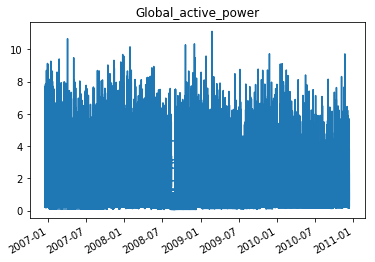

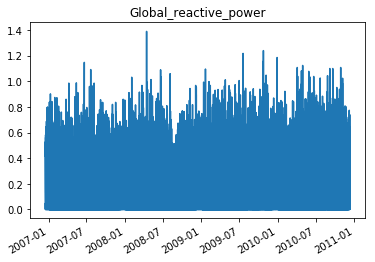

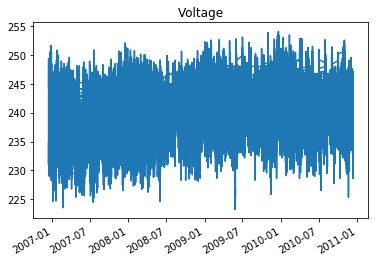

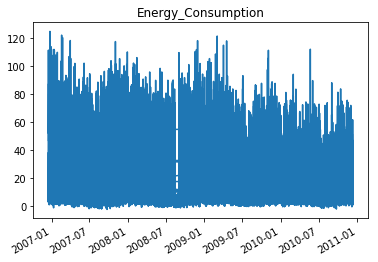

In [4]:
plotGraphs('Global_active_power')
plotGraphs('Global_reactive_power')
plotGraphs('Voltage')
plotGraphs('Energy_Consumption')


We can see from the graphs that the data of these different attributes is balanced over time. 

There are some minimum spikes during certain periods of time. We see that there is a significant minimum spike around the time of September 2008 in the Global active power graph. We notice the same spike around that time in the Energy consumption graph as well, which lead us to understand that the energy consumption is influenced by the global average power.


Below we present some metrics describing the scatter of all the values.

In [5]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Energy_Consumption
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,9.314693e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,9.585916e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.036667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


#### Energy Consumption per Hour

Lets look at the average and sum of the energy consumption per hour. We can see that the samples vary in the same manner but it's noticable that over time the values are changing more drastically. We might resample the data to average values of every hour instead of minutes to see how it affects the fitting later.

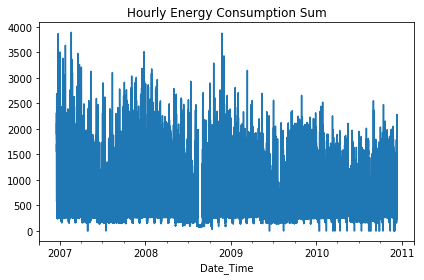

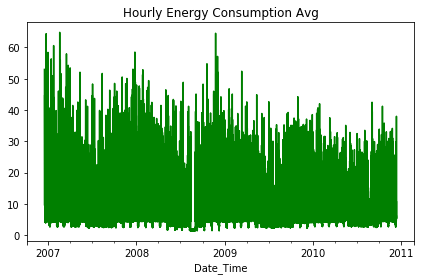

In [6]:
data.Energy_Consumption.resample('H').sum().plot(title='Hourly Energy Consumption Sum') 
#df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red') 
plt.tight_layout()
plt.show()   

data.Energy_Consumption.resample('H').mean().plot(title='Hourly Energy Consumption Avg', color='green') 
plt.tight_layout()
plt.show()

#### Energy Consumption per Day

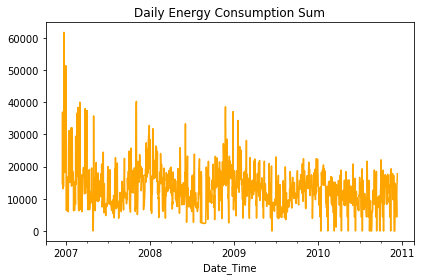

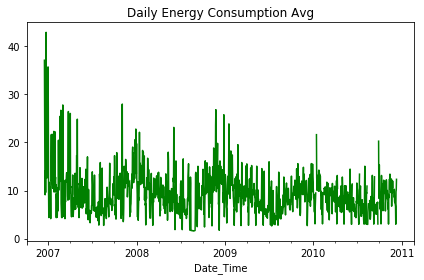

In [8]:
data.Energy_Consumption.resample('D').sum().plot(title='Daily Energy Consumption Sum', color='orange')
#df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red') 
plt.tight_layout()
plt.show()   

data.Energy_Consumption.resample('D').mean().plot(title='Daily Energy Consumption Avg', color='green') 
plt.tight_layout()
plt.show()

We can see from these two graphs that the average and sum of the dataset seem to have similar structure over time. 


#### Energy Comsumption correlation with other values:

Lets see some correlation between different attribute values and the energy consumption. We will see how those variables impact the value of the energy consumption. 
There is a high amount of minute samples so we've addressed the hourly average of the correlation between the values.

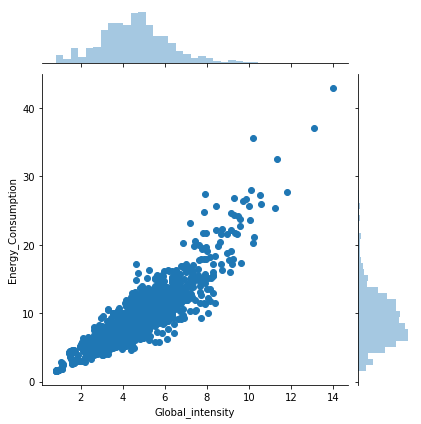

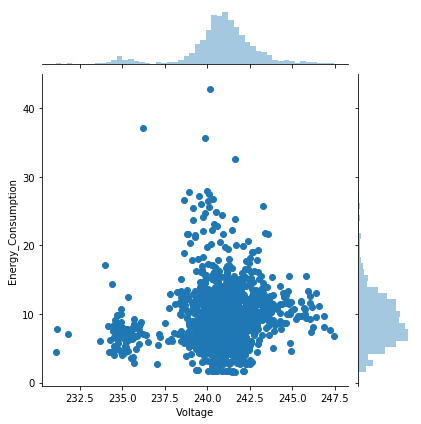

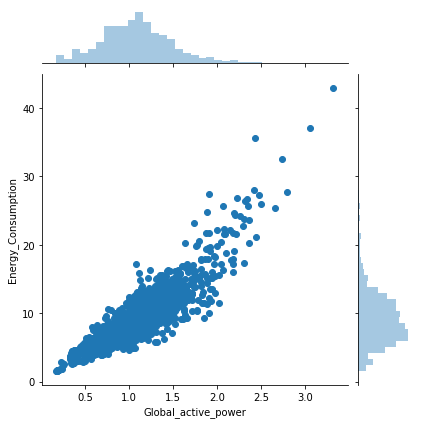

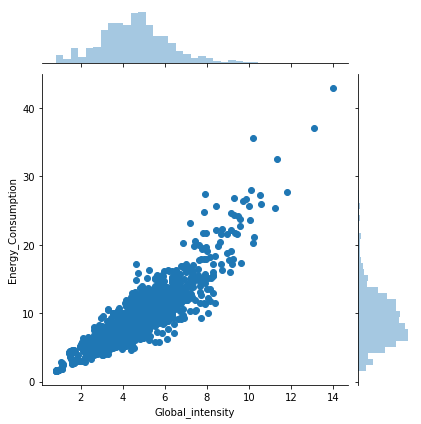

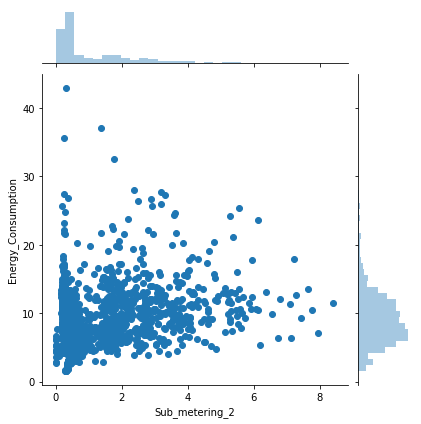

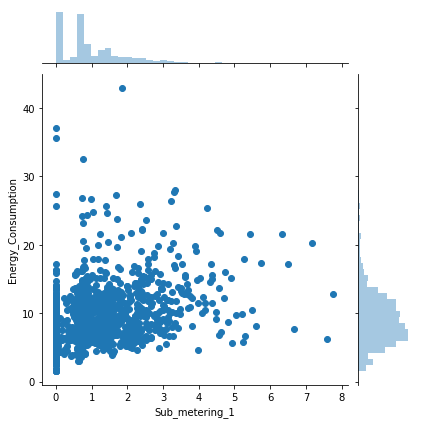

In [12]:
#data_returns = data.pct_change()
sns.jointplot(x=data.Global_intensity.resample('D').mean(), y=data.Energy_Consumption.resample('D').mean(), data=data)  
plt.show()

sns.jointplot(x=data.Voltage.resample('D').mean(), y=data.Energy_Consumption.resample('D').mean(), data=data)  
plt.show()

sns.jointplot(x=data.Global_active_power.resample('D').mean(), y=data.Energy_Consumption.resample('D').mean(), data=data)  
plt.show()

sns.jointplot(x=data.Global_intensity.resample('D').mean(), y=data.Energy_Consumption.resample('D').mean(), data=data)  
plt.show()

sns.jointplot(x=data.Sub_metering_2.resample('D').mean(), y=data.Energy_Consumption.resample('D').mean(), data=data)  
plt.show()

sns.jointplot(x=data.Sub_metering_1.resample('D').mean(), y=data.Energy_Consumption.resample('D').mean(), data=data)  
plt.show()

We see from these graphs that the global active power and the intensity have a similar impact on the energy consumption and seems to be of linear nature. 

### Normalizing the data:

In order to get better results we will normalize the data for each attribute by computing the mean and std.

In [13]:
def normalize(col):
    mean = np.mean(data[col])
    std = np.std(data[col])
    data[col] = (data[col]-mean)/std

In [14]:
energyMean = np.mean(data['Energy_Consumption'])
energyStd = np.std(data['Energy_Consumption'])
normalize('Global_active_power')
normalize('Global_reactive_power')
normalize('Voltage')
normalize('Global_intensity')
normalize('Sub_metering_1')
normalize('Sub_metering_2')
normalize('Sub_metering_3')
normalize('Energy_Consumption')

data[:20]


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Energy_Consumption
Date_Time,,,,,,,,
2006-12-16 17:24:00,2.955077,2.610721,-1.851816,3.098789,-0.182337,-0.051274,1.249421,4.480739
2006-12-16 17:25:00,4.037085,2.770406,-2.225274,4.133800,-0.182337,-0.051274,1.130897,6.574088
2006-12-16 17:26:00,4.050326,3.320432,-2.330213,4.133800,-0.182337,0.120487,1.249421,6.389790
2006-12-16 17:27:00,4.063567,3.355917,-2.191324,4.133800,-0.182337,-0.051274,1.249421,6.518451
2006-12-16 17:28:00,2.434881,3.586573,-1.592556,2.513782,-0.182337,-0.051274,1.249421,3.524474
2006-12-16 17:29:00,2.296793,3.533345,-1.796260,2.333780,-0.182337,0.120487,1.249421,3.166310
2006-12-16 17:30:00,2.468930,3.515602,-1.774655,2.513782,-0.182337,-0.051274,1.249421,3.587066
2006-12-16 17:31:00,2.467039,3.515602,-1.734532,2.513782,-0.182337,-0.051274,1.249421,3.583589
2006-12-16 17:32:00,2.436773,3.426888,-2.114163,2.513782,-0.182337,-0.051274,1.249421,3.527952


We will use LSTM in order to predict the current energy consumption based on the attributes from the previous time frame, for now we will look one minute back. Also we will drop the unwanted columns from the data to make sure that the model fits only on the attributes that belong to past samples.

In [15]:
def Preprocess(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
processedData = Preprocess(data, 1, 1)
processedData.drop(processedData.columns[[7,8,9,10,11,12,13,14]], axis=1, inplace=True)

In [17]:
processedData[:20]

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t)
Date_Time,,,,,,,,
2006-12-16 17:25:00,2.955077,2.610721,-1.851816,3.098789,-0.182337,-0.051274,1.249421,6.574088
2006-12-16 17:26:00,4.037085,2.770406,-2.225274,4.133800,-0.182337,-0.051274,1.130897,6.389790
2006-12-16 17:27:00,4.050326,3.320432,-2.330213,4.133800,-0.182337,0.120487,1.249421,6.518451
2006-12-16 17:28:00,4.063567,3.355917,-2.191324,4.133800,-0.182337,-0.051274,1.249421,3.524474
2006-12-16 17:29:00,2.434881,3.586573,-1.592556,2.513782,-0.182337,-0.051274,1.249421,3.166310
2006-12-16 17:30:00,2.296793,3.533345,-1.796260,2.333780,-0.182337,0.120487,1.249421,3.587066
2006-12-16 17:31:00,2.468930,3.515602,-1.774655,2.513782,-0.182337,-0.051274,1.249421,3.583589
2006-12-16 17:32:00,2.467039,3.515602,-1.734532,2.513782,-0.182337,-0.051274,1.249421,3.527952
2006-12-16 17:33:00,2.436773,3.426888,-2.114163,2.513782,-0.182337,-0.051274,1.249421,3.517520


## Part 2: Forming a neural network graph

#### Validation strategy:

We decided to split the data into train and test sets; out of 47 months of samples (sample for each minute), we took 2.5 years for training, and left the rest (1.5 years) for the test set. 

In [18]:
# 913 hours is 2 and half years - goes to train, and the rest goes for testing 
# split into train and test sets
values = processedData.values
n_train_hours = 913 * 24 * 60
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1314720, 1, 7) (1314720,) (734559, 1, 7) (734559,)


We now have 1314720 samples for training and 734559 samples for testing. It's a good amount of samples to train the model with.  

## Creating a baseline solution and calculating train and validation score accordingly:

We are predicting the energy consumption value, which is dependent on other attributes’ values. The formula to calculate it is:

(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) 

The model will try to look at the values of past values (one minute ago).


## Training and fitting the model:



We are fitting the model, starting to training it for 15 epochs with a batch size of 40.

In [19]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=15, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 1314720 samples, validate on 734559 samples
Epoch 1/15
 - 60s - loss: 0.1393 - val_loss: 0.1158
Epoch 2/15
 - 64s - loss: 0.1232 - val_loss: 0.1152
Epoch 3/15
 - 59s - loss: 0.1201 - val_loss: 0.1089
Epoch 4/15
 - 67s - loss: 0.1175 - val_loss: 0.1069
Epoch 5/15
 - 70s - loss: 0.1160 - val_loss: 0.1062
Epoch 6/15
 - 63s - loss: 0.1151 - val_loss: 0.1065
Epoch 7/15
 - 62s - loss: 0.1142 - val_loss: 0.1047
Epoch 8/15
 - 60s - loss: 0.1137 - val_loss: 0.1038
Epoch 9/15
 - 60s - loss: 0.1134 - val_loss: 0.1043
Epoch 10/15
 - 66s - loss: 0.1131 - val_loss: 0.1048
Epoch 11/15
 - 63s - loss: 0.1128 - val_loss: 0.1050
Epoch 12/15
 - 64s - loss: 0.1126 - val_loss: 0.1037
Epoch 13/15
 - 67s - loss: 0.1123 - val_loss: 0.1038
Epoch 14/15
 - 62s - loss: 0.1121 - val_loss: 0.1036
Epoch 15/15
 - 64s - loss: 0.1119 - val_loss: 0.1037


Lets present a graph of the train and the test loss: 

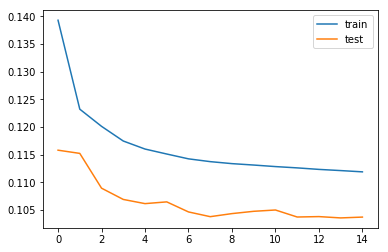

In [20]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


We see that the model acts as we expect; it's improving better on the train samples, rather than on the test samples. Although, it does improve on the test samples over time. The model we train doesn't seem to be overfitted. 

## Results: 



#### Let's predict the results on the test set:

In [58]:
preds = model.predict(test_X)

In [59]:
def revertNormalization(val):
    return val*energyStd + energyMean

predsDF = pd.DataFrame(data = preds)
#predsDF.apply(lambda x: revertNormalization(x), axis=1)
testDF = pd.DataFrame(data = test_y)
#testDF.apply(lambda x: revertNormalization(x), axis=1)


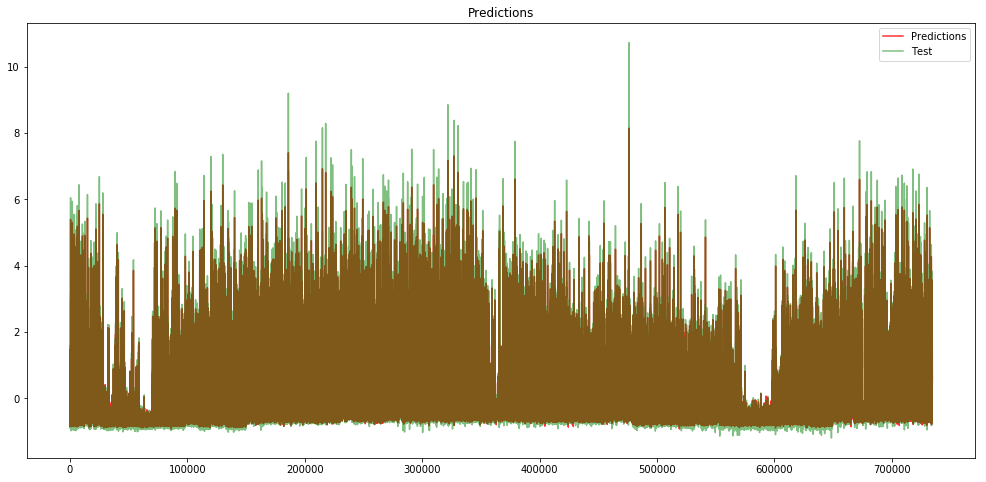

In [60]:
plt.figure(figsize=(17,8))
plt.plot(predsDF,c='red',alpha=0.8,label='Predictions')
plt.plot(testDF,c='green',alpha=0.5,label='Test')
plt.title('Predictions')
plt.legend()

In [61]:
from sklearn.metrics import r2_score 

print('The score of model1 is:')
print(r2_score(testDF.values,predsDF.values))

The score of model1 is:
0.9147159739131537


From the graph above we see that the predictions seem to be close to the actual values for the Energy consumption. We see some difference from the actual values, but overall it seems relatively close. 
The biggest problem is that when the Energy consumption is high, the model is having trouble to predict the correct values. Lets look at a limited period of samples over a week.

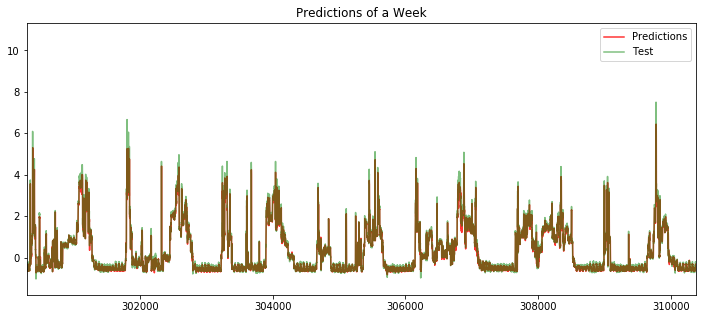

In [62]:
plt.figure(figsize=(12,5))
plt.plot(predsDF,c='red',alpha=0.8,label='Predictions')
plt.plot(testDF,c='green',alpha=0.5,label='Test')
plt.xlim(300300,310380)
plt.title('Predictions of a Week')
plt.legend()

We can see the model doesn't make accurate predictions when the Energy_Consumption is high. We also can notice there is a pattern that repeats 7 times which we suppose represents the day-night enerrgy consuption during this paticular week. Lets go deeper and look at a certain day. 

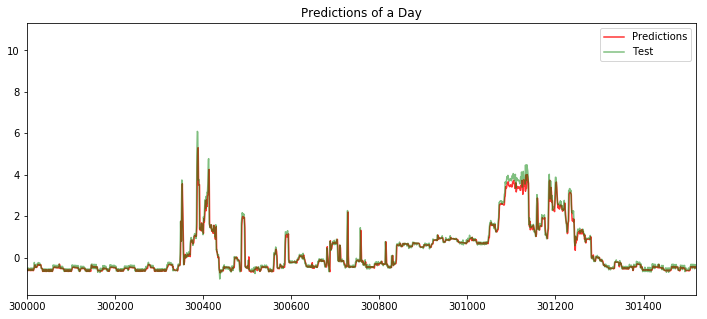

In [63]:
plt.figure(figsize=(12,5))
plt.plot(predsDF,c='red',alpha=0.8,label='Predictions')
plt.plot(testDF,c='green',alpha=0.5,label='Test')
plt.xlim(300000,301520)
plt.title('Predictions of a Day')
plt.legend()

Were able to see the energy consumption in the house for one single day and learn where the model is having trouble prediction the correct consumption level, this occures at the peaks of the function. We can learn from the location of the peaks that they occure during the morning and the evening part of the day because usually these are the the actual peak times of energy consumption every day.
The model seems to predict fairly well the consumption cycle over a day and a week

### Adding 25 more neurons to the LSTM layer and new activation

We would like to investigate the effect of varying and increaing the number of neurons in the network. 

The number of neurons affects the learning capacity of the network. Generally, more neurons would be able to learn more structure from the problem at the cost of longer training time. More learning capacity also creates the problem of potentially overfitting the training data.

We also add a linear activation to the dense layer as the energy consumption is linear relative to the data that is provided from the sample.

We will try fiting the model with 75 neurons, instead of 50. 

In [68]:
from keras.layers import Dropout

# design network
model4 = Sequential()
model4.add(LSTM(75, input_shape=(train_X.shape[1], train_X.shape[2])))
model4.add(Dense(1, activation = 'linear'))
model4.compile(loss='mae', optimizer='adam')
# fit network
history = model4.fit(train_X, train_y, epochs=15, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 1314720 samples, validate on 734559 samples
Epoch 1/15
 - 44s - loss: 0.1443 - val_loss: 0.1238
Epoch 2/15
 - 49s - loss: 0.1269 - val_loss: 0.1157
Epoch 3/15
 - 44s - loss: 0.1219 - val_loss: 0.1105
Epoch 4/15
 - 44s - loss: 0.1184 - val_loss: 0.1073
Epoch 5/15
 - 45s - loss: 0.1166 - val_loss: 0.1054
Epoch 6/15
 - 44s - loss: 0.1154 - val_loss: 0.1045
Epoch 7/15
 - 46s - loss: 0.1148 - val_loss: 0.1042
Epoch 8/15
 - 44s - loss: 0.1142 - val_loss: 0.1054
Epoch 9/15
 - 44s - loss: 0.1138 - val_loss: 0.1048
Epoch 10/15
 - 44s - loss: 0.1136 - val_loss: 0.1042
Epoch 11/15
 - 44s - loss: 0.1131 - val_loss: 0.1043
Epoch 12/15
 - 44s - loss: 0.1128 - val_loss: 0.1041
Epoch 13/15
 - 44s - loss: 0.1126 - val_loss: 0.1033
Epoch 14/15
 - 44s - loss: 0.1124 - val_loss: 0.1030
Epoch 15/15
 - 44s - loss: 0.1122 - val_loss: 0.1028


In [69]:
preds4 = model4.predict(test_X)

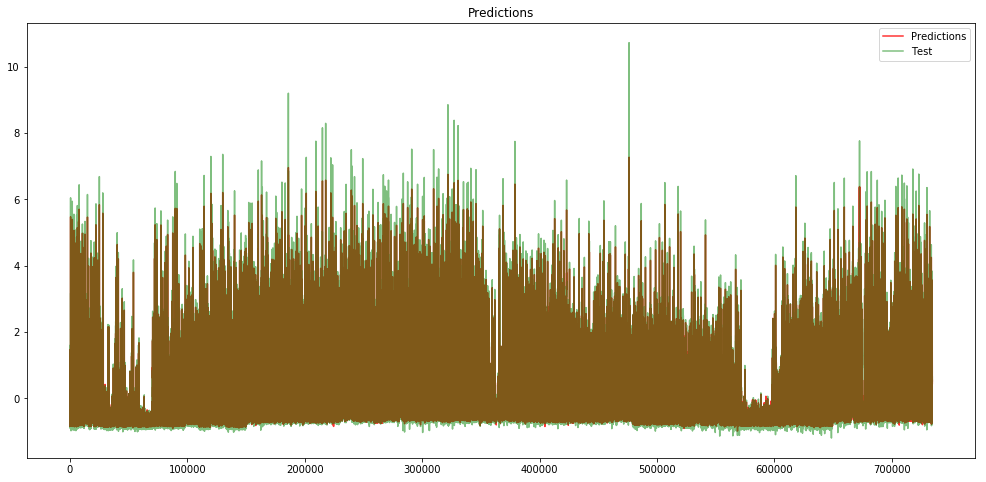

In [71]:
predsDF4 = pd.DataFrame(data = preds4)

plt.figure(figsize=(17,8))
plt.plot(predsDF4,c='red',alpha=0.8,label='Predictions')
plt.plot(testDF,c='green',alpha=0.5,label='Test')
plt.title('Predictions')
plt.legend()

In [78]:
print('The score of model4 is:')
print(r2_score(testDF.values,predsDF4.values))

The score of model4 is:
0.9150368324551444


The model didnt improve after we added more neurons, This might be the result of overfitting. Lets take a closer look at the same day again while comparing the results of our 2 models. 

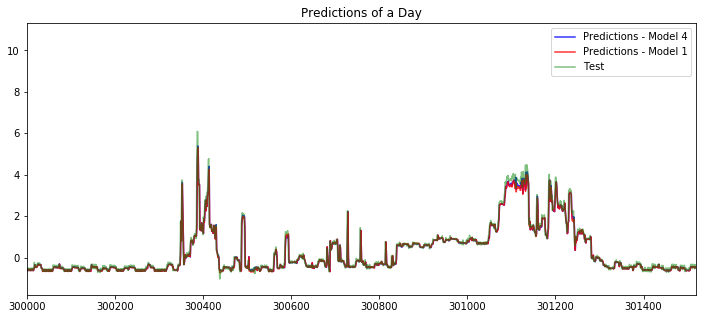

In [76]:
plt.figure(figsize=(12,5))
plt.plot(predsDF4,c='blue',alpha=0.8,label='Predictions - Model 4')
plt.plot(predsDF,c='red',alpha=0.8,label='Predictions - Model 1')
plt.plot(testDF,c='green',alpha=0.5,label='Test')
plt.xlim(300000,301520)
plt.title('Predictions of a Day')
plt.legend()

We can see that model 4 is handling the peaks a bit better than model 1. 
We see that here the val_loss 0.1028, as opposed to 0.1037 without this improvement. Adding more neurons did improve the model, but not significantly. 


## Improving the model with a dropout layer

### Adding dropout layer

In order to improve the model, we will add a dropout layer with a dropout of 20%

In [75]:

# design network
model2 = Sequential()
model2.add(LSTM(75, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation = 'linear'))
model2.compile(loss='mae', optimizer='adam')
# fit network
history = model2.fit(train_X, train_y, epochs=15, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 1314720 samples, validate on 734559 samples
Epoch 1/15
 - 61s - loss: 0.1582 - val_loss: 0.1256
Epoch 2/15
 - 49s - loss: 0.1435 - val_loss: 0.1251
Epoch 3/15
 - 48s - loss: 0.1425 - val_loss: 0.1250
Epoch 4/15
 - 49s - loss: 0.1420 - val_loss: 0.1254
Epoch 5/15
 - 51s - loss: 0.1413 - val_loss: 0.1242
Epoch 6/15
 - 48s - loss: 0.1405 - val_loss: 0.1239
Epoch 7/15
 - 49s - loss: 0.1397 - val_loss: 0.1231
Epoch 8/15
 - 50s - loss: 0.1394 - val_loss: 0.1264
Epoch 9/15
 - 52s - loss: 0.1391 - val_loss: 0.1237
Epoch 10/15
 - 52s - loss: 0.1389 - val_loss: 0.1258
Epoch 11/15
 - 49s - loss: 0.1387 - val_loss: 0.1255
Epoch 12/15
 - 50s - loss: 0.1386 - val_loss: 0.1247
Epoch 13/15
 - 57s - loss: 0.1375 - val_loss: 0.1183
Epoch 14/15
 - 53s - loss: 0.1361 - val_loss: 0.1163
Epoch 15/15
 - 54s - loss: 0.1360 - val_loss: 0.1160


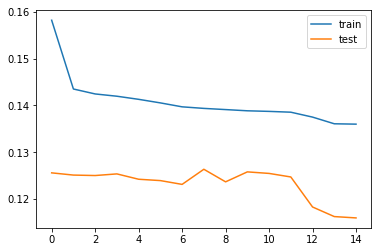

In [80]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [79]:
preds2 = model2.predict(test_X)

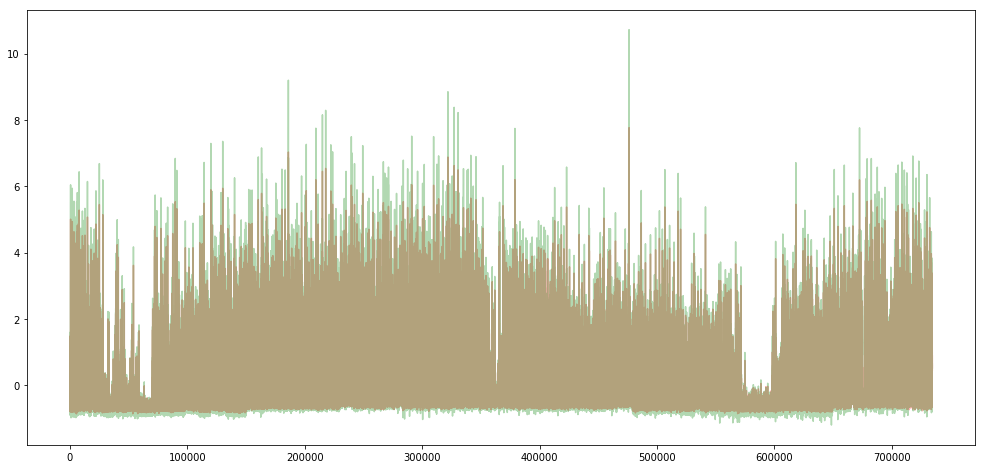

In [81]:
predsDF2 = pd.DataFrame(data = preds2)

plt.figure(figsize=(17,8))
plt.plot(predsDF2,c='red',alpha=0.8,label='Predictions')
plt.plot(testDF,c='green',alpha=0.5,label='Test')
plt.title('Predictions')
plt.legend()

In [82]:
print('The score of model2 is:')
print(r2_score(testDF.values,predsDF2.values))

The score of model2 is:
0.9099019110868959


We see that the dropout didn't improve the model; on the other hand here the val_loss is 0.1160 while without the dropout layer it was 0.1027. 
Unfortunately, the dropout layer improvement wasn't useful, but it means that there is no overfitting problem without the dropout. 

### Running the best model for a longer run

Lets try to run the best model - model 1 for more epochs and a larger batch to see if we can improve further the model.

In [84]:
history = model.fit(train_X, train_y, epochs=15, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 1314720 samples, validate on 734559 samples
Epoch 1/15
 - 30s - loss: 0.1108 - val_loss: 0.1021
Epoch 2/15
 - 35s - loss: 0.1108 - val_loss: 0.1017
Epoch 3/15
 - 33s - loss: 0.1108 - val_loss: 0.1015
Epoch 4/15
 - 32s - loss: 0.1108 - val_loss: 0.1015
Epoch 5/15
 - 31s - loss: 0.1107 - val_loss: 0.1020
Epoch 6/15
 - 33s - loss: 0.1107 - val_loss: 0.1014
Epoch 7/15
 - 31s - loss: 0.1107 - val_loss: 0.1012
Epoch 8/15
 - 39s - loss: 0.1107 - val_loss: 0.1014
Epoch 9/15
 - 34s - loss: 0.1107 - val_loss: 0.1011
Epoch 10/15
 - 35s - loss: 0.1106 - val_loss: 0.1011
Epoch 11/15
 - 37s - loss: 0.1107 - val_loss: 0.1011
Epoch 12/15
 - 34s - loss: 0.1106 - val_loss: 0.1007
Epoch 13/15
 - 30s - loss: 0.1107 - val_loss: 0.1013
Epoch 14/15
 - 30s - loss: 0.1106 - val_loss: 0.1013
Epoch 15/15
 - 33s - loss: 0.1106 - val_loss: 0.1013


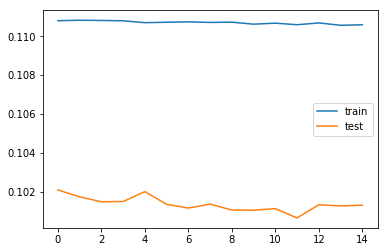

In [85]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [86]:
preds = model.predict(test_X)
print('The score of model is:')
print(r2_score(testDF.values,preds))

The score of model is:
0.9155483473264212


The model improved a little bit but not significantly. We stop here to avoid overfitting.

## Resampling the data from minutes to hours

We resample the data by averaging the values for every minute to an hourly average value. We wish to see how it affects the loss, and what results we will receive.  

In [87]:
data_resample = data.resample('h').mean() 
processedHourlyData = Preprocess(data_resample, 1, 1)
processedHourlyData.drop(processedHourlyData.columns[[7,8,9,10,11,12,13,14]], axis=1, inplace=True)
processedHourlyData[:20]

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t)
Date_Time,,,,,,,,
2006-12-16 18:00:00,2.961593,0.934029,-1.912344,3.031288,-0.182337,-0.132384,1.232959,2.883256
2006-12-16 19:00:00,2.402913,-0.387512,-1.932012,2.468782,-0.182337,0.930629,1.233618,3.050225
2006-12-16 20:00:00,2.183516,-0.341381,-2.347960,2.222029,-0.182337,0.023156,1.211888,2.960394
2006-12-16 21:00:00,2.058984,-0.431278,-2.089008,2.090027,-0.182337,-0.223036,1.223741,2.502952
2006-12-16 22:00:00,1.858378,-0.417379,-1.136175,1.894275,-0.182337,-0.151468,1.275101,2.377189
2006-12-16 23:00:00,1.048449,-0.599243,-0.641934,1.101516,-0.182337,-0.200134,-0.240023,2.604027
2006-12-17 00:00:00,0.917422,-0.463806,-0.067961,0.960515,-0.182337,-0.208722,-0.765477,2.252585
2006-12-17 01:00:00,0.747996,-0.188793,0.037647,0.787263,-0.182337,-0.142880,-0.765477,2.219435
2006-12-17 02:00:00,2.135437,0.117270,-0.120841,2.164278,-0.182337,4.111080,-0.765477,1.728900


In [88]:
# 913 hours is 2 and half years - goes to train, and the rest goes for testing 
# split into train and test sets
values = processedHourlyData.values
n_train_hours = 913 * 24 
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X2, train_y2 = train[:, :-1], train[:, -1]
test_X2, test_y2 = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X2 = train_X2.reshape((train_X2.shape[0], 1, train_X2.shape[1]))
test_X2 = test_X2.reshape((test_X2.shape[0], 1, test_X2.shape[1]))
print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape)

(21912, 1, 7) (21912,) (12235, 1, 7) (12235,)


In [100]:

# design network
model3 = Sequential()
model3.add(LSTM(50, input_shape=(train_X2.shape[1], train_X2.shape[2])))
model3.add(Dense(1))
model3.compile(loss='mae', optimizer='adam')
# fit network
history = model3.fit(train_X2, train_y2, epochs=15, batch_size=10, validation_data=(test_X2, test_y2), verbose=2, shuffle=False)


Train on 21912 samples, validate on 12235 samples
Epoch 1/15
 - 6s - loss: 0.3932 - val_loss: 0.2848
Epoch 2/15
 - 6s - loss: 0.3441 - val_loss: 0.2844
Epoch 3/15
 - 6s - loss: 0.3431 - val_loss: 0.2849
Epoch 4/15
 - 6s - loss: 0.3425 - val_loss: 0.2844
Epoch 5/15
 - 4s - loss: 0.3417 - val_loss: 0.2843
Epoch 6/15
 - 5s - loss: 0.3413 - val_loss: 0.2838
Epoch 7/15
 - 5s - loss: 0.3408 - val_loss: 0.2829
Epoch 8/15
 - 6s - loss: 0.3405 - val_loss: 0.2831
Epoch 9/15
 - 6s - loss: 0.3403 - val_loss: 0.2828
Epoch 10/15
 - 5s - loss: 0.3399 - val_loss: 0.2826
Epoch 11/15
 - 5s - loss: 0.3398 - val_loss: 0.2827
Epoch 12/15
 - 5s - loss: 0.3394 - val_loss: 0.2824
Epoch 13/15
 - 5s - loss: 0.3393 - val_loss: 0.2830
Epoch 14/15
 - 5s - loss: 0.3390 - val_loss: 0.2830
Epoch 15/15
 - 4s - loss: 0.3388 - val_loss: 0.2831


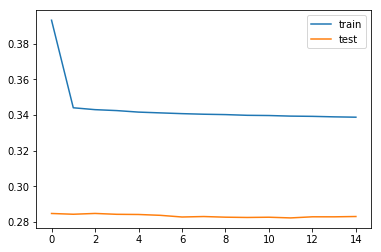

In [101]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [102]:
preds3 = model3.predict(test_X2)

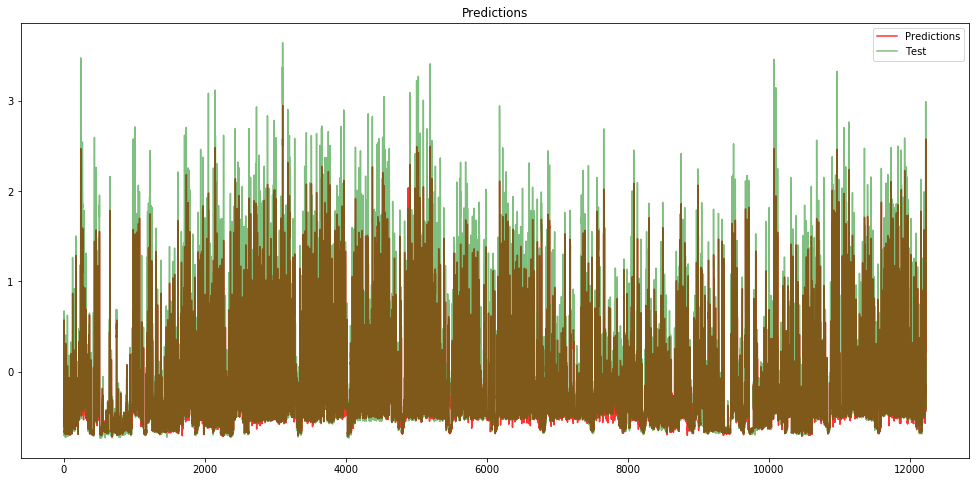

In [103]:
predsDF3 = pd.DataFrame(data = preds3)
htestDF = pd.DataFrame(data = test_y2)

plt.figure(figsize=(17,8))
plt.plot(predsDF3,c='red',alpha=0.8,label='Predictions')
plt.plot(htestDF,c='green',alpha=0.5,label='Test')
plt.title('Predictions')
plt.legend()

In [104]:
print('The score of the hour model is:')
print(r2_score(htestDF.values,preds3))

The score of the hour model is:
0.5191502797909731


We see that averaging the values for every hour did not help as alot of data is lost when we transition from minute samples to average hourly samples. It makes sense as here the model has less samples to train on, therefore it provides worse results. 



## Resampling the data from minutes to days

In [105]:
data_resample = data.resample('d').mean() 
processedDailyData = Preprocess(data_resample, 1, 1)
processedDailyData.drop(processedDailyData.columns[[7,8,9,10,11,12,13,14]], axis=1, inplace=True)
processedDailyData[:20]

values = processedDailyData.values
n_train_days = 913 
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X3, train_y3 = train[:, :-1], train[:, -1]
test_X3, test_y3 = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X3 = train_X3.reshape((train_X3.shape[0], 1, train_X3.shape[1]))
test_X3 = test_X3.reshape((test_X3.shape[0], 1, test_X3.shape[1]))
print(train_X3.shape, train_y3.shape, test_X3.shape, test_y3.shape)

(913, 1, 7) (913,) (503, 1, 7) (503,)


In [108]:

# design network
model5 = Sequential()
model5.add(LSTM(50, input_shape=(train_X3.shape[1], train_X3.shape[2])))
model5.add(Dense(1))
model5.compile(loss='mae', optimizer='adam')
# fit network
history = model5.fit(train_X3, train_y3, epochs=15, batch_size=40, validation_data=(test_X3, test_y3), verbose=2, shuffle=False)


Train on 913 samples, validate on 503 samples
Epoch 1/15
 - 1s - loss: 0.3636 - val_loss: 0.2474
Epoch 2/15
 - 0s - loss: 0.3304 - val_loss: 0.2332
Epoch 3/15
 - 0s - loss: 0.3079 - val_loss: 0.2241
Epoch 4/15
 - 0s - loss: 0.2952 - val_loss: 0.2181
Epoch 5/15
 - 0s - loss: 0.2881 - val_loss: 0.2134
Epoch 6/15
 - 0s - loss: 0.2841 - val_loss: 0.2100
Epoch 7/15
 - 0s - loss: 0.2811 - val_loss: 0.2075
Epoch 8/15
 - 0s - loss: 0.2789 - val_loss: 0.2056
Epoch 9/15
 - 0s - loss: 0.2770 - val_loss: 0.2039
Epoch 10/15
 - 0s - loss: 0.2757 - val_loss: 0.2029
Epoch 11/15
 - 0s - loss: 0.2747 - val_loss: 0.2019
Epoch 12/15
 - 0s - loss: 0.2738 - val_loss: 0.2006
Epoch 13/15
 - 0s - loss: 0.2732 - val_loss: 0.1994
Epoch 14/15
 - 0s - loss: 0.2727 - val_loss: 0.1985
Epoch 15/15
 - 0s - loss: 0.2722 - val_loss: 0.1977


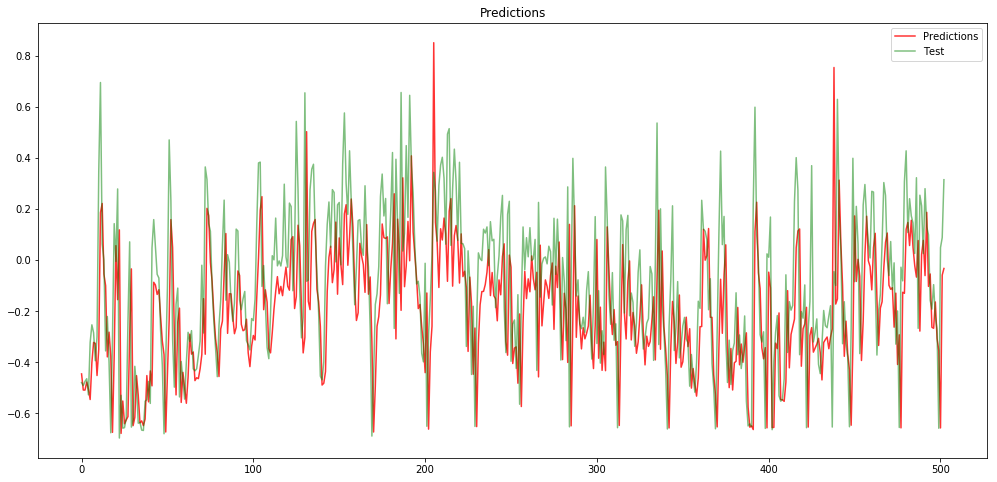

In [112]:
preds5 = model3.predict(test_X3)
predsDF5 = pd.DataFrame(data = preds5)
dtestDF = pd.DataFrame(data = test_y3)

plt.figure(figsize=(17,8))
plt.plot(predsDF5,c='red',alpha=0.8,label='Predictions')
plt.plot(dtestDF,c='green',alpha=0.5,label='Test')
plt.title('Predictions')
plt.legend()

In [113]:
print('The score of the day model is:')
print(r2_score(dtestDF.values,preds5))

The score of the day model is:
0.11565366809982713


## Fitting a classical machine learning model to the data to get a better benchmark:

We will use a Linear Regression Machine Learning algorithm. 
The linear model assumes a linear relationship between the input variables (x) and the single output variable (y).

In [114]:
from sklearn.linear_model import LinearRegression

noTarget = processedData.drop('var8(t)',axis = 1)
nminutes = 913 * 24 * 60 
mlTrain = noTarget[:1314720]
mlTarget = processedData['var8(t)'][:nminutes]
mlTest = noTarget[1314720:]
lm = LinearRegression()
lm.fit(mlTrain,mlTarget)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [115]:
mlpreds = lm.predict(mlTest)

0.9068495283165829

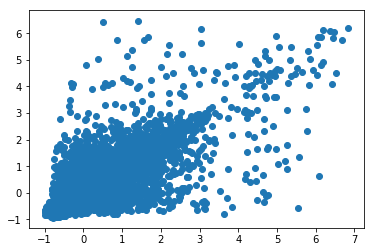

In [116]:
from sklearn.metrics import classification_report

plt.scatter(test_y[:100000],mlpreds[:100000])
lm.score(mlTest, test_y)

We received a score of 0.90 using this approach. Most of the values aspire to the diagonal, as we excpected. 
From reviewing the accuracy of this model and the loss of the previous model. Our model got score of 91.4% which is good compared to the ML benchmark model.